In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amazon-fine-food-reviews/hashes.txt
/kaggle/input/amazon-fine-food-reviews/Reviews.csv
/kaggle/input/amazon-fine-food-reviews/database.sqlite


In [2]:
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense,Dropout,Input,LSTM,BatchNormalization
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import concatenate
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.layers import Bidirectional

import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [3]:
from tensorflow.keras.layers import Attention
from bs4 import BeautifulSoup

In [4]:
df = pd.read_csv('/kaggle/input/amazon-fine-food-reviews/Reviews.csv', delimiter=',',nrows=5000)
df.shape

(5000, 10)

In [5]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [11]:
# Printing first example
print(df['Text'][0])
print()
print(df['Summary'][0])

I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.

Good Quality Dog Food


## Dropping duplicate and NaN values

In [12]:
df.dropna(axis=0,inplace=True)
df.drop_duplicates(subset=['Text'],inplace=True)

## Preprocessing

In [13]:
astrophe_words = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

In [14]:
def astrophe_preprocess(text):
    l = []
    for txt in text.split(" "):
        if txt in set(astrophe_words.keys()):
            l.append(astrophe_words[txt])
        
        else:
            l.append(txt)
    
    out = " ".join(l)
    return out

In [15]:
len(df['Text'])

4984

In [16]:
# Code to check if HTML tags are present or not
def has_html_tags(text):
    # Regular expression pattern to match HTML tags
    html_tag_pattern = r'<[^>]+>'
    
    for i in range(len(text)):
        # Search for the first occurrence of an HTML tag in the text
        match = re.search(html_tag_pattern, text[i])
        
        if match is not None:
            print(i)
            return True
    
    return False

print(has_html_tags(text = df['Text']))

10
True


In [17]:
df['Text'][10]

"I don't know if it's the cactus or the tequila or just the unique combination of ingredients, but the flavour of this hot sauce makes it one of a kind!  We picked up a bottle once on a trip we were on and brought it back home with us and were totally blown away!  When we realized that we simply couldn't find it anywhere in our city we were bummed.<br /><br />Now, because of the magic of the internet, we have a case of the sauce and are ecstatic because of it.<br /><br />If you love hot sauce..I mean really love hot sauce, but don't want a sauce that tastelessly burns your throat, grab a bottle of Tequila Picante Gourmet de Inclan.  Just realize that once you taste it, you will never want to use any other sauce.<br /><br />Thank you for the personal, incredible service!"

In [18]:
out = BeautifulSoup(df['Text'][10], "lxml").text
out

"I don't know if it's the cactus or the tequila or just the unique combination of ingredients, but the flavour of this hot sauce makes it one of a kind!  We picked up a bottle once on a trip we were on and brought it back home with us and were totally blown away!  When we realized that we simply couldn't find it anywhere in our city we were bummed.Now, because of the magic of the internet, we have a case of the sauce and are ecstatic because of it.If you love hot sauce..I mean really love hot sauce, but don't want a sauce that tastelessly burns your throat, grab a bottle of Tequila Picante Gourmet de Inclan.  Just realize that once you taste it, you will never want to use any other sauce.Thank you for the personal, incredible service!"

In [19]:
def text_preprocess(text):
    t = text.lower()
    # Getting text from HTML tags
    t = BeautifulSoup(t, "lxml").text
    
    # Remove all text within parenthesis
    t = re.sub(r'\([^)]*\)', '', t)
    
    # Remove " 
    t = re.sub('"','',t)
    
    # Change astrophe words
    t = astrophe_preprocess(t) 
    
    # Remove 's
    t = re.sub(r"'s\b","",t)
    
    # Replacing all non-alphabetic characters
    t = re.sub("[^a-zA-Z]", " ", t) 
    
    return t.strip()

In [20]:
cleaned_text = []
for txt in df['Text']:
    cleaned_text.append(text_preprocess(txt))

In [21]:
cleaned_text[10]

'i do not know if it is the cactus or the tequila or just the unique combination of ingredients  but the flavour of this hot sauce makes it one of a kind   we picked up a bottle once on a trip we were on and brought it back home with us and were totally blown away   when we realized that we simply could not find it anywhere in our city we were bummed now  because of the magic of the internet  we have a case of the sauce and are ecstatic because of it if you love hot sauce  i mean really love hot sauce  but do not want a sauce that tastelessly burns your throat  grab a bottle of tequila picante gourmet de inclan   just realize that once you taste it  you will never want to use any other sauce thank you for the personal  incredible service'

In [22]:
import spacy

# Load the English language model for spaCy
nlp = spacy.load("en_core_web_sm")

def lemmatize_sentence(sentence):
    # Process the sentence using spaCy
    doc = nlp(sentence)
    
    # Lemmatize each word in the sentence and join them back
    lemmatized_sentence = ' '.join(token.lemma_ for token in doc)
    
    return lemmatized_sentence

# Example
sentence = "The quick brown foxes are jumping over the lazy dogs"
lemmatized_sentence = lemmatize_sentence(sentence)
print(lemmatized_sentence)

the quick brown fox be jump over the lazy dog


In [23]:
final_text = []
for txt in cleaned_text:
    final_text.append(lemmatize_sentence(txt))

In [24]:
len(final_text)

4984

### Summary Preprocessing

In [25]:
df['Summary'][:10]

0                            Good Quality Dog Food
1                                Not as Advertised
2                            "Delight" says it all
3                                   Cough Medicine
4                                      Great taffy
5                                       Nice Taffy
6    Great!  Just as good as the expensive brands!
7                           Wonderful, tasty taffy
8                                       Yay Barley
9                                 Healthy Dog Food
Name: Summary, dtype: object

In [26]:
def summary_cleaner(text):
    t = re.sub('"','', text)
    t = astrophe_preprocess(t)    
    t = re.sub(r"'s\b","",t)
    t = re.sub("[^a-zA-Z]", " ", t)
    t = t.lower()
    t = t.split()
    
    newString=''
    
    for i in t:
        if len(i)>1:                                 
            newString=newString+i+' '  
    
    return newString

#Call the above function
cleaned_summary = []
for t in df['Summary']:
    cleaned_summary.append(summary_cleaner(t))

In [27]:
df['cleaned_text']= final_text
df['cleaned_summary']=cleaned_summary
df['cleaned_summary'].replace('', np.nan, inplace=True)
df.dropna(axis=0,inplace=True)

In [28]:
df['cleaned_summary'] = df['cleaned_summary'].apply(lambda x : '_START_ '+ x + ' _END_')

In [29]:
# Printing few examples of Data
for i in range(5):
    print("Review:",df['cleaned_text'][i])
    print("Summary:",df['cleaned_summary'][i])
    print()

Review: I have buy several of the vitality can dog food product and have find they all to be of good quality   the product look more like a stew than a process meat and it smell well   my labrador be finicky and she appreciate this product well than   most
Summary: _START_ good quality dog food  _END_

Review: product arrive label as jumbo salt peanut    the peanut be actually small sized unsalted   not sure if this be an error or if the vendor intend to represent the product as jumbo
Summary: _START_ not as advertised  _END_

Review: this be a confection that have be around a few century    it be a light   pillowy citrus gelatin with nut    in this case filbert   and it be cut into tiny square and then liberally coat with powdered sugar    and it be a tiny mouthful of heaven    not too chewy   and very flavorful    I highly recommend this yummy treat    if you be familiar with the story of c s   lewis   the lion   the witch   and the wardrobe    this be the treat that seduce edmund in

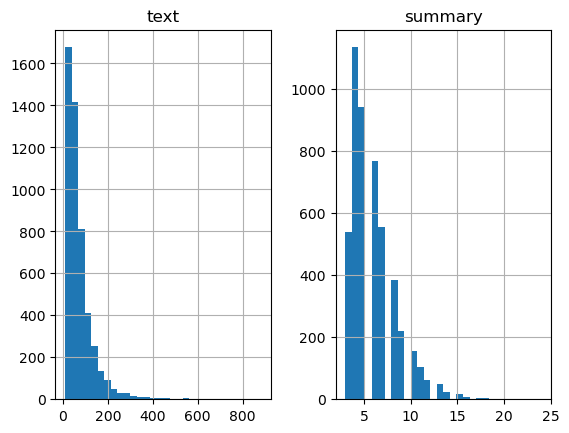

In [30]:
import matplotlib.pyplot as plt
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in df['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in df['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})
length_df.hist(bins = 30)
plt.show()

In [31]:
max_in_len =400  # Max text length chosen based on distribution
max_tr_len =20   # Max summary length

In [32]:
from sklearn.model_selection import train_test_split
x_train,x_val,y_train,y_val = train_test_split(df['cleaned_text'],df['cleaned_summary'],test_size=0.2,random_state=0,shuffle=True)

# Transformer Model

In [33]:
from transformers import pipeline, set_seed

import matplotlib.pyplot as plt
from datasets import load_dataset
import pandas as pd
from datasets import load_dataset, load_metric

from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

import nltk
from nltk.tokenize import sent_tokenize

from tqdm import tqdm
import torch

nltk.download("punkt")

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [34]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

model_ckpt = "google/pegasus-cnn_dailymail"

tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

model_pegasus = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt)

In [35]:
print(x_train[0])
print(y_train[0])

I have buy several of the vitality can dog food product and have find they all to be of good quality   the product look more like a stew than a process meat and it smell well   my labrador be finicky and she appreciate this product well than   most
_START_ good quality dog food  _END_


In [36]:
train_input_encodings = tokenizer(list(x_train) , max_length = 400, truncation = True, padding = True )

with tokenizer.as_target_tokenizer():
        train_target_encodings = tokenizer(list(y_train), max_length = 20, truncation = True, padding = True )

In [37]:
val_input_encodings = tokenizer(list(x_val) , max_length = 400, truncation = True, padding = True )

with tokenizer.as_target_tokenizer():
        val_target_encodings = tokenizer(list(y_val), max_length = 20, truncation = True, padding = True )

In [38]:
from transformers import TrainingArguments, Trainer

trainer_args = TrainingArguments(
    output_dir='pegasus', 
    num_train_epochs=1,
    per_device_train_batch_size=1, per_device_eval_batch_size=1,
    gradient_accumulation_steps=16)

In [39]:
from torch.utils.data import Dataset

class MyDataset(Dataset):
    def __init__(self, encodings, target_encodings):
        self.encodings = encodings
        self.target_encodings = target_encodings

    def __len__(self):
        return len(self.encodings["input_ids"])

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.target_encodings["input_ids"][idx])
        return item
    

train_data = MyDataset(train_input_encodings, train_target_encodings)
val_data = MyDataset(val_input_encodings, val_target_encodings)

In [40]:
trainer = Trainer(model=model_pegasus, 
                  args=trainer_args,
                  tokenizer=tokenizer,
                  train_dataset=train_data,
                  eval_dataset = val_data
                 )

In [41]:
trainer.train()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


You're using a PegasusTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss


TrainOutput(global_step=249, training_loss=4.763829242752259, metrics={'train_runtime': 828.9131, 'train_samples_per_second': 4.806, 'train_steps_per_second': 0.3, 'total_flos': 4496728994611200.0, 'train_loss': 4.763829242752259, 'epoch': 1.0})

In [42]:
def generate_batch_sized_chunks(list_of_elements, batch_size):
    """split the dataset into smaller batches that we can process simultaneously
    Yield successive batch-sized chunks from list_of_elements."""
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i : i + batch_size]

In [43]:
def calculate_metric_on_test_ds(x_val,y_val, metric, model, tokenizer, batch_size=16):
    
    article_batches = list(generate_batch_sized_chunks(list(x_val), batch_size))
    target_batches = list(generate_batch_sized_chunks(list(y_val), batch_size))

    for article_batch, target_batch in zip(article_batches, target_batches):
        
        inputs = tokenizer(article_batch, max_length=400,  truncation=True, padding=True, return_tensors="pt")
        
        # Move inputs to the same device as the model (cuda:0)
        inputs = {k: v.to(model.device) for k, v in inputs.items()}
        
        summaries = model.generate(input_ids=inputs["input_ids"],attention_mask=inputs["attention_mask"], 
                                   length_penalty=0.8, num_beams=8, max_length=128)
        ''' parameter for length penalty ensures that the model does not generate sequences that are too long. '''
        
        # Finally, we decode the generated texts, 
        # replace the  token, and add the decoded texts with the references to the metric.
        decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True, clean_up_tokenization_spaces=True) for s in summaries]      
        
        decoded_summaries = [d.replace("", " ") for d in decoded_summaries]
        
        
        metric.add_batch(predictions=decoded_summaries, references=target_batch)
        
    #  Finally compute and return the ROUGE scores.
    score = metric.compute()
    return score

In [44]:
!pip install rouge_score

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24954 sha256=a36bb76e65f7d31ff25974123aa6fcaebefcbf85de3c4f9e1bb6bd717620caf2
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [45]:
from datasets import load_metric
rouge_metric = load_metric("rouge")

In [46]:
torch.cuda.empty_cache()

In [47]:
score = calculate_metric_on_test_ds(x_val, y_val, rouge_metric, trainer.model, tokenizer, batch_size = 1)

rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]

rouge_dict = dict((rn, score[rn].mid.fmeasure ) for rn in rouge_names )

pd.DataFrame(rouge_dict, index = [f'pegasus'])

,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.0,0.0,0.0,0.0
